<a href="https://colab.research.google.com/github/mkstt/Reference-Repo/blob/master/PolyAI_ConveRT%5Beng%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[PolyAI](https://github.com/PolyAI-LDN/polyai-models/blob/master/examples/convert-examples.ipynb)

In [0]:
!pip install --no-deps tensorflow_text==0.1.0

     |████████████████████████████████| 6.2MB 4.0MB/s 


In [0]:
!pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 377.0MB 47kB/s 
     |████████████████████████████████| 3.2MB 42.8MB/s 
     |████████████████████████████████| 491kB 63.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
ERROR: tensorflow-text 0.1.0 has requirement tensorflow<1.15,>=1.14, but you'll have tensorflow 1.15.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
# Import the required dependencies

import tensorflow_hub as tfhub
import tensorflow as tf
import tensorflow_text  # required for tokenization ops

sess = None

assert tf.__version__ == "1.14.0", (
    f"found tf version {tf.__version__}, but need 1.14.0")
assert tf.test.is_gpu_available(), (
    "GPU not available. please use a GPU runtime")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 


## Computing sentence encodings


---


The default signature for ConveRT encodes sentences to a meaningful semantic space. Sentences can be compared for semantic similarity in this space, and NLP classifiers can be trained on top of these encodings.

This section demonstrates encoding texts with ConveRT, and computing similarities.


In [0]:
 #Load the tensorflow hub module into a fresh session.

if sess is not None:
    sess.close()

sess = tf.InteractiveSession(graph=tf.Graph())

module = tfhub.Module("http://models.poly-ai.com/convert/v1/model.tar.gz")

text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])
encoding_tensor = module(text_placeholder)
encoding_dim = int(encoding_tensor.shape[1])
print(f"ConveRT encodes text to {encoding_dim}-dimensional vectors")

sess.run(tf.tables_initializer())
sess.run(tf.global_variables_initializer())


def encode(texts):
    """Encode the given texts to the encoding space."""
    return sess.run(encoding_tensor, feed_dict={text_placeholder: texts})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ConveRT encodes text to 1024-dimensional vectors


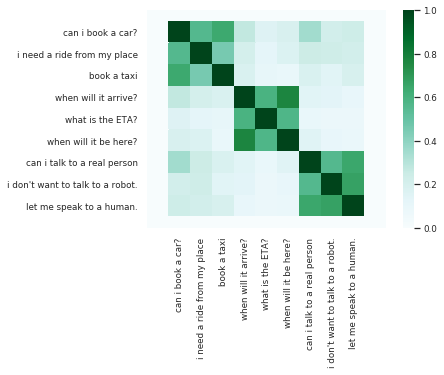

In [0]:
#  Compute the similarity between a collection of sentences.

import numpy as np
from sklearn.metrics import pairwise
import seaborn

texts = [
         # booking a ride
         "can i book a car?",
         "i need a ride from my place",
         "book a taxi",

         # asking for ETA
         "when will it arrive?",
         "what is the ETA?",
         "when will it be here?",

         # asking to talk to a human
         "can i talk to a real person",
         "i don't want to talk to a robot.",
         "let me speak to a human.",
]

# Pad with "" to make heatmap display better.
texts = [""] + texts + [""]

encodings = encode(texts)

similarities = pairwise.cosine_similarity(encodings)
seaborn.set(font_scale=0.8)
g = seaborn.heatmap(
    similarities,
    xticklabels=texts,
    yticklabels=texts,
    vmin=0.,
    vmax=1.,
    cmap="BuGn",
    square=True,
)

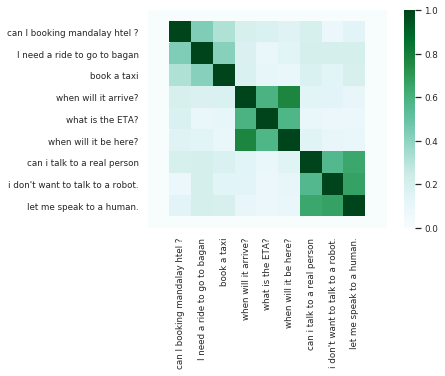

In [0]:
texts = [
         # booking hotel
         "can I booking mandalay htel ?",
         "I need a ride to go to bagan",
         "book a taxi",

         # asking for ETA
         "when will it arrive?",
         "what is the ETA?",
         "when will it be here?",

         # asking to talk to a human
         "can i talk to a real person",
         "i don't want to talk to a robot.",
         "let me speak to a human.",
]

# Pad with "" to make heatmap display better.
texts = [""] + texts + [""]

encodings = encode(texts)

similarities = pairwise.cosine_similarity(encodings)
seaborn.set(font_scale=0.8)
g = seaborn.heatmap(
    similarities,
    xticklabels=texts,
    yticklabels=texts,
    vmin=0.,
    vmax=1.,
    cmap="BuGn",
    square=True,

)

## Response Ranking


---
ConveRT is trained on the response ranking task, so it can be used to find good responses to a given conversational context.

This section demonstrates how to rank responses, by computing cosine similarities of context and response representations in the shared response ranking space. Response representations for a fixed candidate list are first pre-computed. When a new context is provided, it is encoded and then compared to the pre-computed response representations.


In [0]:
if sess is not None:
    sess.close()

sess = tf.InteractiveSession(graph=tf.Graph())

module = tfhub.Module("http://models.poly-ai.com/convert/v1/model.tar.gz")

text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])
context_encoding_tensor = module(text_placeholder, signature="encode_context")
response_encoding_tensor = module(text_placeholder, signature="encode_response")

encoding_dim = int(context_encoding_tensor.shape[1])
print(f"ConveRT encodes contexts & responses to {encoding_dim}-dimensional vectors")

sess.run(tf.tables_initializer())
sess.run(tf.global_variables_initializer())

def encode_contexts(texts):
    return sess.run(context_encoding_tensor, feed_dict={text_placeholder: texts})

def encode_responses(texts):
    return sess.run(response_encoding_tensor, feed_dict={text_placeholder: texts})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ConveRT encodes contexts & responses to 512-dimensional vectors


In [0]:
# Pre-encode responses.
# Download a file of random facts to serve as candidate responses for the demo.
!wget -q https://raw.githubusercontent.com/assaf/dailyhi/a35ba9fc1744dfb399d82abbc5f2d4e4216fbd45/facts.txt -O facts.txt

import numpy as np
import random

responses = []
with open("facts.txt") as f:
    for line in f:
        responses.append(line.strip())

print("\n\t- ".join(["Three random facts:"] + random.sample(responses, 3)))

# Encode the responses in batches of 64.
batch_size = 64
response_encodings = []
for i in range(0, len(responses), batch_size):
    batch = responses[i:i + batch_size]
    response_encodings.append(encode_responses(batch))

response_encodings = np.concatenate(response_encodings)
print(f"Encoded {response_encodings.shape[0]} candidate responses.")

Three random facts:
	- A 13-year-old boy in India produced winged beetles in his urine after hatching the eggs in his body
	- On average, a person has two million sweat glands
	- The YKK on the zipper of your Levis stands for Yoshida Kogyo Kabushibibaisha, the worlds largest zipper manufacturer
Encoded 3090 candidate responses.


In [0]:
#@title Rank responses { run: "auto" }
#@markdown Find the best response in a list of around 3 thousand random facts. 
context = "Can you tell me about flight ?" # @param {type:"string"}
if context:
    context_encoding = encode_contexts([context])
    scores = np.dot(response_encodings, context_encoding.T)
    top_index = np.argmax(scores)
    top_score = float(scores[top_index])
    print(f"[{top_score:.3f}] {responses[top_index]}")

[0.365] Castaways Travel, a Houston-area travel agency, offers an all-nude flight to Cancun Mexico. Once the plane reaches cruising altitude, you are allowed to take off all your clothes and roam about the cabin


## Multi-Context ConveRT



---
The multi-context version of ConveRT has the same interface as ConveRT, except that when encoding contexts, it also takes extra dialogue history as input.

The extra context must be passed as a single string, where earlier contexts are joined with spaces from most recent to oldest.

An example from the ConveRT paper, where extra contexts would help is:

    Student: I’m looking for good courses to take.

    Advisor: Are you looking for courses in a specific area?

    Student: Not in particular.

    Advisor: Are you looking to take a very difficult class?

This section will demonstrate how Multi-context ConveRT can be used to select that last response from the Advisor. (Without more context that "Not in particular", this would be hard).



In [0]:
import numpy as np

if sess is not None:
    sess.close()

sess = tf.InteractiveSession(graph=tf.Graph())

module = tfhub.Module("http://models.poly-ai.com/multi_context_convert/v1/model.tar.gz")

text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])
extra_text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])

# The encode_context signature now also takes the extra context.
context_encoding_tensor = module(
    {
        'context': text_placeholder,
        'extra_context': extra_text_placeholder,
    },
    signature="encode_context"
)
response_encoding_tensor = module(text_placeholder, signature="encode_response")

encoding_dim = int(context_encoding_tensor.shape[1])
print(f"ConveRT encodes contexts & responses to {encoding_dim}-dimensional vectors")

sess.run(tf.tables_initializer())
sess.run(tf.global_variables_initializer())

def encode_context(dialogue_history):
    """Encode the dialogue context to the response ranking vector space.

    Args:
        dialogue_history: a list of strings, the dialogue history, in
            chronological order.
    """

    # The context is the most recent message in the history.
    context = dialogue_history[-1]

    extra_context = list(dialogue_history[:-1])
    extra_context.reverse()
    extra_context_feature = " ".join(extra_context)

    return sess.run(
        context_encoding_tensor,
        feed_dict={
            text_placeholder: [context],
            extra_text_placeholder: [extra_context_feature],
        }
    )[0]

def encode_responses(texts):
    return sess.run(response_encoding_tensor, feed_dict={text_placeholder: texts})


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ConveRT encodes contexts & responses to 512-dimensional vectors


In [0]:
context_encoding = encode_context(
    [
     "I'm looking for good courses to take.",
     "Are you looking for courses in a specific area?",
     "Not in particular.",
     ]
)

candidate_responses = [
    "Me neither.",
    # We hope it selects the following sentence:
    "Are you looking to take a very difficult class?",
    "Why not?",
    "Please finish the exercise first.",
    "Nothing in particular?",
    "Would you like fries with that?",
    "School's for fools, look at me!",
    "Our higher education system is one of the things that makes America exceptional.",
]
response_encodings = encode_responses(candidate_responses)

scores = context_encoding.dot(response_encodings.T)
top_idx = np.argmax(scores)

print(
    f"Best response:\n\t'{candidate_responses[top_idx]}'\n"
    f"\t\tscore: {scores[top_idx]:.3f}"
)

indices = np.argsort(scores)[::-1][1:]
print("Other responses:")
for index in indices:
    print(
        f"\t'{candidate_responses[index]}'\n"
        f"\t\tscore: {scores[index]:.3f}"
    )

Best response:
	'Are you looking to take a very difficult class?'
		score: 0.439
Other responses:
	'Nothing in particular?'
		score: 0.285
	'Why not?'
		score: 0.137
	'Me neither.'
		score: 0.113
	'Please finish the exercise first.'
		score: 0.084
	'Our higher education system is one of the things that makes America exceptional.'
		score: 0.055
	'Would you like fries with that?'
		score: 0.025
	'School's for fools, look at me!'
		score: 0.016
